# Linker Dev Notebook

In [7]:
import sys
from pathlib import Path
import pickle
import uuid
import cv2
import numpy as np
from rich import progress

# make data for development
path = Path("data")
obj_files = [f for f in path.glob("*.obj")]
im_files = [f for f in path.glob("*.png")]
print(f"{len(obj_files)} .obj files and {len(im_files)} .png files found in {path} path")
labels = [pickle.load(open(str(f), "rb")) for f in obj_files]

class State(): pass
state = State()

state.objs = dict()
for label in progress.track(labels, description="[green] Loading object labels"): 
    state.objs[label["frame_idx"]] = label["objs"]

# put images into structure by frame_idx
ims = dict()
for f in progress.track(im_files, description="[green] Loading images"): 
    ims[int(f.stem)] = cv2.imread(str(f))


Output()

90 .obj files and 90 .png files found in data path


Output()

In [28]:
"""
Add & Link 

The linker matches objects in a series of images.
The track formed is a list of objects. 
The linker algorithm is separate from the track management.
Simple data structures (lists, dict) are preferred to classes. 
Functions that transform the data structures are preferred to class attributes.
Start with the simple case of matching by size and distance. 
Suitable for processing a recorded video, not a live video feed.

"""
from copy import deepcopy
import numpy as np
from matplotlib import pyplot as plt

def add_obj_to_track(tracks, track_idx, frame_idx, obj): 
    obj["track_idx"] = track_idx
    tracks[(track_idx, frame_idx)] = obj

def match_obj_in_next_frame(obj, objs, 
                            dist_max_filt=True, dist_max_filt_m=200, dist_max_filt_k=1.25,
                            dist_wt=1, dist_square=True, 
                            area_wt=1, area_square=True,
                            error_threshold=1e3
                            ): 
    """ """    
    if dist_max_filt: 
        dist_max = dist_max_filt_m + obj["obj_area"]**dist_max_filt_k
        to_remove = []
        for obj_idx in objs: 
            obj_a = obj["obj_centroid"]
            obj_b = objs[obj_idx]["obj_centroid"]
            if np.linalg.norm(obj_a-obj_b) > dist_max: 
                to_remove.append(obj_idx)
        for obj_idx in to_remove: 
            objs.pop(obj_idx)
        if len(objs) == 0: 
            return None
        
    dists = np.array([np.linalg.norm(objs[obj_idx]["obj_centroid"] - obj["obj_centroid"]) for obj_idx in objs])
    areas = np.array([objs[obj_idx]["obj_area"] - obj["obj_area"] for obj_idx in objs])
    obj_idxs = np.array(list(objs))
    
    dists = dists*dist_wt
    areas = areas*area_wt
    
    if dist_square: dists = dists**2
    if area_square: areas = areas**2
    
    error = dists + areas

    idx_min = np.argmin(error)
    if error[idx_min] < error_threshold: 
        return obj_idxs[idx_min]
    else: 
        return None

def add_and_link(objs, tracks, n_frames, frame_idx_start, new_obj_idxs, next_track_idx):
    """ """ 
    new_track_idxs = list(range(next_track_idx, next_track_idx+len(new_obj_idxs)))
    tracks_idxs = new_track_idxs.copy()
    # create new track for each new obj requested in frame_idx
    for obj_idx in new_obj_idxs: 
        obj = objs[frame_idx_start][obj_idx]
        add_obj_to_track(tracks, tracks_idxs.pop(), frame_idx_start, obj)
    
    # track through n_frames
    for track_idx in progress.track(new_track_idxs, description="[green] linking objects"):     
        for frame_idx in range(frame_idx_start, frame_idx_start+n_frames-1): 
            obj = tracks[(track_idx, frame_idx)]
            obj_idx = match_obj_in_next_frame(obj, deepcopy(objs[frame_idx+1]))
            if obj_idx is None: 
                break # this track is terminated
            else: 
                add_obj_to_track(tracks, track_idx, frame_idx+1, objs[frame_idx+1][obj_idx])

def mpl_plot_tracks(im, frame_idx, tracks): 
    """ """
    f, ax = plt.subplots(1,1, dpi=150, figsize=(4.5, 4.5))
    ax.imshow(im)
    
    def _plot_single(track_idx, frame_idx, 
               show_lines=True, line_width=0.5, line_color="b", 
               show_markers=True, marker=".", marker_size=4, mc="g"): 
        """ """
        keys = [key for key in tracks if ((key[0]==track_idx) & (key[1]<=frame_idx))]
        last_marker_color = {True: "g", False: "r"}[keys[-1][1]==frame_idx]
        cents = np.array([tracks[key]["obj_centroid"] for key in keys])

        if show_markers: 
            ax.plot(cents[:-1,0], cents[:-1,1], marker=marker, markersize=2, color=mc, linestyle="None")
        
        ax.plot(cents[-1,0], cents[-1,1], marker=marker, markersize=2, color=last_marker_color, linestyle="None")
        
        if show_lines: 
            ax.plot(cents[:,0], cents[:,1], ls="-", lw=line_width, color=line_color)
    
    track_idxs = set([l[0] for l in list(tracks.keys())])
    _ = [_plot_single(track_idx, frame_idx, show_markers=False) for track_idx in track_idxs]

state.next_track_idx = 1
state.tracks = dict()

objs = state.objs
tracks = state.tracks

next_track_idx = state.next_track_idx
frame_idx_start = 10
n_frames = 80

new_obj_idxs = list(state.objs[frame_idx_start].keys())  # new objs to track in this frame: by loc in frame or user selection
add_and_link(objs, tracks, frame_idx_start, new_obj_idxs, next_track_idx)
next_track_idx = max(set([l[0] for l in list(tracks.keys())])) + 1



Output()

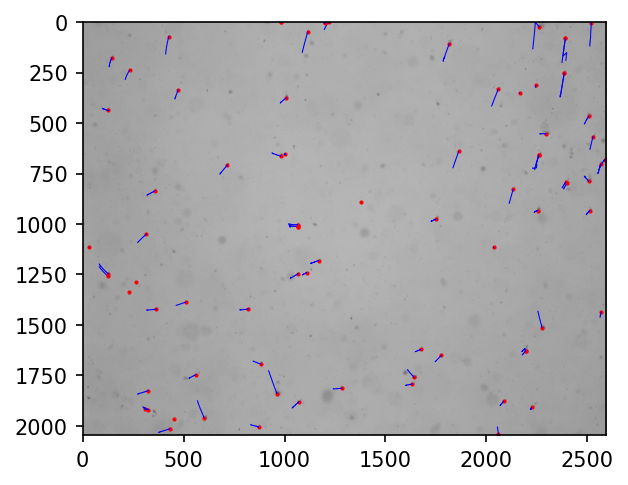

In [24]:
# make a plot of all the tracks up to current frame
frame_idx = frame_idx_start+n_frames
mpl_plot_tracks(ims[frame_idx], frame_idx, tracks)

In [25]:
max(set([1,23,4,5,66,99]))

99